In [1]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode
from plotly.offline import iplot as iplot_offline
from plotly.offline import plot as plot_offline
from plotly.plotly import iplot, plot
from plotly.graph_objs import Scatter
# from plotly.tools import FigureFactory as FF

%matplotlib inline
import matplotlib as plt
plt.style.use('ggplot')
import scripts.daily_data as dd
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import graph_objs

import requests

In [2]:
TBP_colors = {
    'red_orange': 'rgb(255, 64, 0)',
    'gold': 'rgb(247,195,24)',
    'orange': 'rgba(236,159,76,1)',
    'orange_sc': 'rgba(236,159,76,0.8)',
    'dark_orange': '#e8800f',
    'gray': '#e6e6e6',
    'light gray': '#f2f2f2',
    'white': 'rgb(255,255,255)',
    'teal': '#6dc3d7',
    'black opaque': 'rgba(0,0,0,0.65)',
    'purple': 'rgb(105,107,165)',
    'red': 'rgb(210,20,4)',
}

In [3]:
!mv /Users/coreypetty/Downloads/2018* ./raw_data/
!mv /Users/coreypetty/Downloads/stats* ./raw_data/

mv: rename /Users/coreypetty/Downloads/stats* to ./raw_data/stats*: No such file or directory


In [7]:
# Move LibSyn Daily Totals downloads
!mv /home/petty/Downloads/The\ Bitcoin\ Podcast\ Network.csv \
./raw_data/2019-02-17_daily-totals.csv

In [4]:
# Move Spotify Daily Totals downloads
!mv /home/petty/Downloads/The\ Bitcoin\ Podcast\ Network.csv \
./raw_data/2019-02-17_daily-totals_spotify.csv

In [5]:
from scripts.daily_data import update_daily_csv_new

In [8]:
# Update the totals file
update_string = ' (updated February 17, 2019)'
file_string = '2019-02-17.csv'
database_file = 'raw_data/daily-totals_2019-01-03.csv'
update_file = 'raw_data/2019-02-17_daily-totals.csv'
dd.update_daily_csv_new(database_file, update_file)

Files exist
pandas DataFrames created
DataFrame structured in new format
Old entries updated with newest data
Adding the following days to the database:
            total_downloads
date                       
2019-01-04             2560
2019-01-05             1431
2019-01-06             2370
2019-01-07             1987
2019-01-08             1608
2019-01-09             2846
2019-01-10             1751
2019-01-11              996
2019-01-12              859
2019-01-13             1921
2019-01-14             1945
2019-01-15             2432
2019-01-16             2772
2019-01-17             2154
2019-01-18             2969
2019-01-19             1777
2019-01-20             2912
2019-01-21             4196
2019-01-22             2398
2019-01-23             2271
2019-01-24             1661
2019-01-25             2380
2019-01-26             1157
2019-01-27             2270
2019-01-28             3598
2019-01-29             3207
2019-01-30             2711
2019-01-31             1996
2019-02

In [9]:
daily_metrics = pd.read_csv("raw_data/daily-totals_" + file_string, index_col=None, parse_dates=[0])

dates = daily_metrics.date
dates = pd.to_datetime(dates)
start = dates[0]
periods = dates - start
periods_days = periods / np.timedelta64(1, 'D')

daily = daily_metrics.set_index('date')
weekly = daily.resample('W').sum()
monthly = daily.resample('M').sum()

In [10]:
# Move LibSyn Episodic Downloads (start from Jan 5, 2018 always)
!mv /home/petty/Downloads/The\ Bitcoin\ Podcast\ Network.csv \
./raw_data/stats_TBP_episodic_2019-02-17.csv

In [11]:
# Move Spotify Episodic Downloads (start from Dec 5, 2017 always)
!mv /home/petty/Downloads/The\ Bitcoin\ Podcast\ Network.csv \
./raw_data/stats_TBP_episodic_2019-02-17_spotify.csv

In [12]:
def convert_legacy_date(date):
    return np.datetime64(datetime.utcfromtimestamp(date.tolist()/1e9).date())

def convert_legacy_title(title):
    return title.replace(' —', ':')

def convert_since_title(title):
    return title.replace('?"', ':')

# Create Legacy Stats DataFrame
episodes_legacy = pd.read_csv('/home/petty/Dropbox/Projects/PycharmProjects/TBP_metrics/raw_data/stats_TBP_episodic_2018-01-05_legacy.csv', 
                                index_col=None, parse_dates=['release_date'])
episodes_legacy = episodes_legacy[['release_date', 'item_title', 'downloads__total']]
episodes_legacy.columns = ['release_date', 'title', 'downloads']
episodes_legacy['release_date'] = [convert_legacy_date(date) for date in episodes_legacy['release_date'].values]

# Create New Stats DataFrame
episodes_since = pd.read_csv('/home/petty/Dropbox/Projects/PycharmProjects/TBP_metrics/raw_data/stats_TBP_episodic_' + file_string,
                                      index_col=None, parse_dates=['Released'])
episodes_since = episodes_since[['Released', 'Title', 'Downloads']]
episodes_since.columns = ['release_date', 'title', 'downloads']
episodes_since['release_date'] = [convert_legacy_date(date) for date in episodes_since['release_date'].values]

# Concatenate appropriately
episodes_legacy['title'] = [convert_legacy_title(title) for title in episodes_legacy['title']]
episodes_since['title'] = [convert_since_title(title) for title in episodes_since['title']]

# episodes_legacy = episodes_legacy.set_index(['release_date', 'title'])
# episodes_since = episodes_since.set_index(['release_date', 'title'])
episodes = pd.merge(episodes_legacy, episodes_since, how='outer', on=['title', 'release_date']).sort_values(by='release_date')
episodes['downloads_x'] = episodes.downloads_x.fillna(0)
episodes['downloads_y'] = episodes.downloads_y.fillna(0)
episodes['downloads'] = episodes.downloads_x + episodes.downloads_y
# episodes = pd.concat([episodes_legacy,episodes_since]).reset_index().sort_values(by='release_date')

# # Get Days of Week DF
release_dates = list(episodes.release_date)

days_of_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_wkdays = daily
df_wkdays['weekday'] = df_wkdays.reset_index().date.dt.dayofweek.values
df_wkdays = df_wkdays.reset_index().pivot(index='date', columns='weekday', values='total_downloads')
df_wkdays.columns = days_of_week.values()

In [13]:
# Include day of week and most recently released episode
def get_unixtime(time):    
    return (time.astype(np.int64)/1e6).astype(np.int64)

trace = go.Scatter(
    name = 'Daily',
    x=daily_metrics.date, 
    y=daily_metrics.total_downloads,
    mode='markers',
    marker = {
        'color': TBP_colors['dark_orange'],
    }
)

trace2 = go.Scatter(
    name = 'Cumulative',
    x = daily_metrics.date,
    y = daily_metrics.total_downloads.cumsum(),
    yaxis = 'y2',
    marker = {
        'color': 'rgba(46, 46, 46,0.5)',
    },
    fill = 'tozeroy',
)

trace3 = go.Scatter(
    name='30-day Ave.',
    x = daily_metrics.date,
    y = daily_metrics.set_index('date').total_downloads.rolling(30).mean(),
    marker = {
        'color': TBP_colors['orange'],
    },
    line = {
        'width': 5,
    }
)

# Get ymax from total_downloads
ymax = daily_metrics.total_downloads.max() + 100

layout = {
    'title': "Daily downloads" + update_string,
    'xaxis': {
        'autorange': False,
        'range': [get_unixtime(daily_metrics.date.values[0]),
                  get_unixtime(daily_metrics.date.values[-1])],
        'gridcolor': '#f2f2f2',
        'zeroline': False,
        'type': 'date',
    },
    'yaxis': {
        'title': 'Daily downloads',
        'gridcolor': '#f2f2f2',
        'zeroline': False,
        'overlaying': 'y2',
#         'domain': [0, daily_metrics.total_downloads.max()]
    },
    'yaxis2': {
        'title': 'Cumulative downloads',
        'gridcolor': '#f2f2f2',
        'zeroline': False,
        'side': 'right',
        'showgrid': False,
    },
    'paper_bgcolor': 'rgba(242,242,242,0)',
    'plot_bgcolor': '#d7d8d8',
    'font': dict(family='Helvetica, sans-serif', size=16, color='#2e2e2e'),
    'showlegend': False,
}

data = [trace, trace2, trace3]
fig = {
    'data': data,
    'layout': layout,
}
# iplot_offline(fig) # offline
py.iplot(fig, filename='TBP_plots/daily_total-downloads') # update online

/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



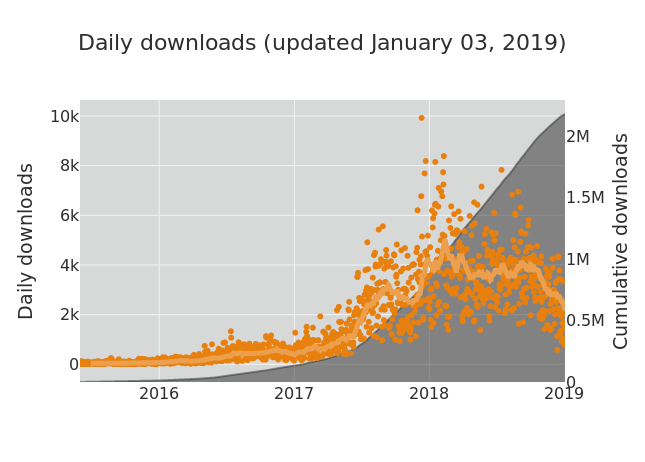

In [7]:
# Include day of week and most recently released episode
def get_unixtime(time):    
    return (time.astype(np.int64)/1e6).astype(np.int64)

trace = go.Scatter(
    name = 'Daily',
    x=daily_metrics.date, 
    y=daily_metrics.total_downloads,
    mode='markers',
    marker = {
        'color': TBP_colors['dark_orange'],
    }
)

trace2 = go.Scatter(
    name = 'Cumulative',
    x = daily_metrics.date,
    y = daily_metrics.total_downloads.cumsum(),
    yaxis = 'y2',
    marker = {
        'color': 'rgba(46, 46, 46,0.5)',
    },
    fill = 'tozeroy',
)

trace3 = go.Scatter(
    name='30-day Ave.',
    x = daily_metrics.date,
    y = daily_metrics.set_index('date').total_downloads.rolling(30).mean(),
    marker = {
        'color': TBP_colors['orange'],
    },
    line = {
        'width': 5,
    }
)

# Get ymax from total_downloads
ymax = daily_metrics.total_downloads.max() + 100

layout = {
    'title': "Daily downloads" + update_string,
    'xaxis': {
        'autorange': False,
        'range': [get_unixtime(daily_metrics.date.values[0]),
                  get_unixtime(daily_metrics.date.values[-1])],
        'gridcolor': '#f2f2f2',
        'zeroline': False,
        'type': 'date',
    },
    'yaxis': {
        'title': 'Daily downloads',
        'gridcolor': '#f2f2f2',
        'zeroline': False,
        'overlaying': 'y2',
#         'domain': [0, daily_metrics.total_downloads.max()]
    },
    'yaxis2': {
        'title': 'Cumulative downloads',
        'gridcolor': '#f2f2f2',
        'zeroline': False,
        'side': 'right',
        'showgrid': False,
    },
    'paper_bgcolor': 'rgba(242,242,242,0)',
    'plot_bgcolor': '#d7d8d8',
    'font': dict(family='Helvetica, sans-serif', size=16, color='#2e2e2e'),
    'showlegend': False,
}

data = [trace, trace2, trace3]
fig = {
    'data': data,
    'layout': layout,
}
iplot_offline(fig) # offline
#py.iplot(fig, filename='TBP_plots/daily_total-downloads') # update online

In [14]:
bar_week = go.Bar(
    x = weekly.index,
    y = weekly.total_downloads,
    marker=dict(
        color=TBP_colors['orange'],
        line=dict(
            color='#e8800f',
            width=1.5,
        )
    ),
    opacity=0.8
)

layout = go.Layout(
    title = 'Weekly Downloads' + update_string,
    yaxis = dict(
        title = 'Total downloads',
        gridcolor='#f2f2f2',
#         zerolinecolor='#969696',
#         showline=True,
    ),
    xaxis = dict(
#         zerolinecolor='#969696'
        gridcolor='#f2f2f2',
#         tickangle=45,
    ),
    paper_bgcolor='rgba(242,242,242,0)',
    plot_bgcolor='#d7d8d8',
    font=dict(family='Helvetica, sans-serif', size=16, color='#2e2e2e'),
    width=1200,
)
fig = dict(data=[bar_week], layout=layout)
# iplot_offline(fig)
iplot(fig, filename='TBP_plots/downloads-weekly')

In [16]:
#  Sort and plot by month
months={'05':"January", '06':'January ', '07':' January','08':'January   ',
        15:"February", 16:"February ", 17:" February",18:"Februrary  ",
        25:"March", 26:"March ", 27:" March", 
        35:"April", 36: "April ", 37: " April", 
        45:"May", 46:"May ", 47:" May", 
        55:"June", 56: "June ", 57: " June", 58: "June  ",
        65:"July", 66:"July ", 67: " July",68: "July  ", 
        75:"August", 76:"August ", 77: " August", 78: "August  ",
        85:"September", 86:"September ", 87:" September", 88:"September  ", 
        95:"October", 96:"October ", 97:" October", 98:"October  ",
        105:"November", 106:"November ", 107:" November", 108:"November  ",
        115:"December", 116:"December ", 117:" December", 118:"December  "}
years={5:"2015", 6:"2016"}
#  Relabel to month name
ts =                  pd.DataFrame(monthly).set_index(pd.Series([55,65,75,85,95,105,115,
                                                '05',15,25,35,45,56,66,76,86,96,106,116,
                                                '06',16,26,36,46,57,67,77,87,97,107,117,
                                                '07',17,27,37,47,58,68,78,88,98,108,118,
                                                '08',18
                                               ]).apply(lambda x: months[x]))
#  Plot

bar_month = go.Bar(
    x = ts.index,
    y = ts.total_downloads,
    marker=dict(
        color=TBP_colors['orange'],
        line=dict(
            color='#e8800f',
#             width=1.5,
        )
    ),
    opacity=0.8
)

layout = go.Layout(
    title = 'Monthly Downloads' + update_string,
    yaxis = dict(
        title = 'Total downloads',
        gridcolor='#f2f2f2',
#         zerolinecolor='#969696',
#         showline=True,
    ),
    xaxis = dict(
#         zerolinecolor='#969696'
        gridcolor='#f2f2f2',
#         tickangle=45,
    ),
    paper_bgcolor='rgba(242,242,242,0)',
    plot_bgcolor='#d7d8d8',
    font=dict(family='Helvetica, sans-serif', size=16, color='#2e2e2e'),
    width=1200,
)
fig = dict(data=[bar_month], layout=layout)
# iplot_offline(fig)
iplot(fig, filename='TBP_plots/downloads-monthly')

In [17]:
def change_bc_title(title):
    if "BlockChannel" in title:
        return title.replace('BlockChannel Episode ', "BC")
    else:
        return title
episodes['title'] = episodes.title.apply(change_bc_title)
# sc_stats['title'] = sc_stats.title.apply(change_bc_title)

In [18]:
# Adding show differentiation
def get_show(title):
    if "BC" in title:
        return 'BlockChannel'
    elif 'On-Ramping' in title:
        return 'On-Ramping with Dee'
    elif 'Announcements' in title:
        return 'TBP Announcements'
    elif 'NABP' in title:
        return 'Not Another Bitcoin Podcast'
    elif 'Ether Review' in title:
        return "The Ether Review"
    elif 'Buy or Sell' in title:
        return "Buy or Sell, What the Hell"
    elif 'An Ethereum' in title:
        return "An Ethereum Podcast"
    elif 'Humanist' in title:
        return 'Creating a Humanist Blockchain Future'
    elif "Hashing It Out" in title:
        return "Hashing It Out"
    else:
        return 'The Bitcoin Podcast'
episodes['show'] = episodes.title.apply(get_show)

In [19]:
# Let's add color differentiation
def get_color(title):
    if "BC" in title:
        return 'rgb(101,174,223)'
#     elif 'TBP' in title:
#         return TBP_colors['orange']
    elif 'On-Ramping' in title:
        return 'rgb(130,170,52)'
    elif 'Announcements' in title:
        return TBP_colors['black opaque']
    elif "Ether Review" in title:
        return TBP_colors['orange']
    elif "NABP" in title:
        return TBP_colors['white']
    elif "Buy or Sell" in title:
        return TBP_colors['gold']
    elif "An Ethereum" in title:
        return TBP_colors['purple']
    elif "Humanist" in title:
        return TBP_colors['red']
    elif "Hashing" in title:
        return TBP_colors['teal']
    else:
        return TBP_colors['orange']
color_column = episodes.title.apply(get_color)
episodes.loc[:,'color'] = color_column

# def get_color_sc(title):
#     if "BC" in title:
#         return 'rgba(101,174,223,0.8)'
#     elif 'TBP' in title:
#         return TBP_colors['dark_orange']
#     elif 'On-Ramping' in title:
#         return 'rgba(130,170,52,0.8)'
#     else:
#         return TBP_colors['orange_sc']
# sc_stats['color'] = sc_stats.title.apply(get_color_sc)

In [20]:
episodes = episodes[episodes.title != "BTCPODcast.mp3"]

In [25]:
episodes_all = go.Bar(
    name = "Whole Network",
    x = episodes.downloads,
    y = episodes.title,
    marker=dict(
        color=episodes.color,
        line=dict(
            color='#e8800f',
            width=0,
        )
    ),
    opacity=0.85,
    orientation = 'h'
)
tbp_mask = (episodes.show == "The Bitcoin Podcast")
episodes_tbp = go.Bar(
    name = "The Bitcoin Podcast",
    x = episodes[tbp_mask].downloads,
    y = episodes[tbp_mask].title,
    marker=dict(
        color=episodes[tbp_mask].color,
        line=dict(
            color='#e8800f',
            width=0,
        )
    ),
    opacity=0.85,
    orientation = 'h',
    visible=False,
)
bc_mask = (episodes.show == "BlockChannel")
episodes_bc = go.Bar(
    name="BlockChannel",
    x = episodes[bc_mask].downloads,
    y = episodes[bc_mask].title,
    marker=dict(
        color=episodes[bc_mask].color,
        line=dict(
            color='#e8800f',
            width=0,
        )
    ),
    opacity=0.85,
    orientation = 'h',
    visible=False,
)
orwd_mask = (episodes.show == "On-Ramping with Dee")
episodes_orwd = go.Bar(
    name="On-Ramping with Dee",
    x = episodes[orwd_mask].downloads,
    y = episodes[orwd_mask].title,
    marker=dict(
        color=episodes[orwd_mask].color,
        line=dict(
            color='#e8800f',
            width=0,
        )
    ),
    opacity=0.85,
    orientation = 'h',
    visible=False
)
awdp_mask = (episodes.show == "TBP Announcements")
episodes_awdp = go.Bar(
    name="TBP Announcements",
    x = episodes[awdp_mask].downloads,
    y = episodes[awdp_mask].title,
    marker=dict(
        color=episodes[awdp_mask].color,
        line=dict(
            color='#e8800f',
            width=0,
        )
    ),
    opacity=0.85,
    orientation = 'h',
    visible=False,
)

ter_mask = (episodes.show == "The Ether Review")
episodes_ter = go.Bar(
    name="The Ether Review",
    x = episodes[ter_mask].downloads,
    y = episodes[ter_mask].title,
    marker=dict(
        color=episodes[ter_mask].color,
        line=dict(
            color='#e8800f',
            width=0,
        )
    ),
    opacity=0.85,
    orientation = 'h',
    visible=False,
)

wth_mask = (episodes.show == "Buy or Sell, What the Hell")
episodes_wth = go.Bar(
    name="Buy or Sell, WTH",
    x = episodes[wth_mask].downloads,
    y = episodes[wth_mask].title,
    marker=dict(
        color=episodes[wth_mask].color,
        line=dict(
            color='#e8800f',
            width=0,
        )
    ),
    opacity=0.85,
    orientation = 'h',
    visible=False,
)

layout = go.Layout(
    barmode="stack",
    title='Downloads by Episode' + update_string,
    hovermode='closest',
    updatemenus=list([
        dict(
            x=-0.1,
            y=1.1,
            yanchor='top',
            bgcolor=TBP_colors['orange_sc'],
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False, False]],
                    label='All',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False, False]],
                    label='The Bitcoin Podcast',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False, False]],
                    label='BlockChannel',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False, False]],
                    label='On-Ramping with Dee',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True, False]],
                    label='TBP Announcements',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, True]],
                    label='The Ether Review',
                    method='restyle'
                )
            ]),
        )
    ]),
    margin=go.Margin(
        l=425,
        r=30,
        b=30,
        t=50,
        pad=4
    ),
    yaxis = dict(
#         title = 'Total downloads',
        gridcolor='#f2f2f2',
#         zerolinecolor='#969696',
#         showline=True,
    ),
    xaxis = dict(
#         zerolinecolor='#969696'
        gridcolor='#f2f2f2',
#         tickangle=45,
    ),
    paper_bgcolor='rgba(242,242,242,0)',
    plot_bgcolor='#d7d8d8',
    font=dict(family='Helvetica, sans-serif', size=16, color='#2e2e2e'),
    width=1200,
    showlegend=False,
#     legend=dict(
#         x=0.8,
#         y=1
#     )
)
fig = dict(data=[episodes_all, episodes_tbp, episodes_bc, episodes_orwd, episodes_awdp, episodes_ter], layout=layout)
# iplot_offline(fig)
iplot(fig, filename='TBP_plots/Downloads by Episode')

/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




In [21]:
barh_episodes = go.Bar(
    name = "LibSyn",
    x = episodes.downloads,
    y = episodes.title,
    marker=dict(
        color=episodes.color.values,
        line=dict(
            color='#e8800f',
            width=0,
        )
    ),
    opacity=0.85,
    orientation = 'h'
)

# barh_sc = go.Bar(
#     name="SoundCloud",
#     x = sc_stats.playback_count,
#     y = sc_stats.title,
#     marker=dict(
#         color=sc_stats.color,
#         line=dict(
#             color='#e8800f',
#             width=0,
#         )
#     ),
#     opacity=0.85,
#     orientation = 'h'
# )

layout = go.Layout(
    barmode="stack",
    title='Downloads by Episode' + update_string,
    margin=go.Margin(
        l=375,
        r=30,
        b=30,
        t=50,
        pad=4
    ),
    yaxis = dict(
#         title = 'Total downloads',
        gridcolor='#f2f2f2',
#         zerolinecolor='#969696',
#         showline=True,
    ),
    xaxis = dict(
#         zerolinecolor='#969696'
        gridcolor='#f2f2f2',
#         tickangle=45,
    ),
    paper_bgcolor='rgba(242,242,242,0)',
    plot_bgcolor='#d7d8d8',
    font=dict(family='Helvetica, sans-serif', size=16, color='#2e2e2e'),
    width=1200,
    legend=dict(
        x=0.8,
        y=1
    )
)
# fig = dict(data=[barh_episodes, barh_sc], layout=layout)
fig = dict(data=[barh_episodes], layout=layout)
# iplot_offline(fig)
iplot(fig, filename='TBP_plots/Downloads by Episode')

/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




In [22]:
averages = []
for x in range(len(episodes)):
    average = episodes.reset_index().loc[:x, 'downloads'].cumsum().values[-1] / (x+1)
    averages.append(average)
trace = go.Scatter(
    x = episodes.set_index('release_date').index,
    y = averages,
    name = "All Time Average",
    line = dict(
        color=TBP_colors['dark_orange']
    ),
    text=episodes.title
)
rolling = go.Scatter(
    x = episodes.set_index('release_date').index[4:],
    y = episodes.set_index('release_date')['downloads'].rolling(10).mean(),
    name = 'Rolling Ave. (10 episodes)',
    line = dict(
        color=TBP_colors['orange']
    ),
)
layout = {
    'title': "Average Downloads per Episode" + update_string,
    'xaxis': {
        'title': 'Episode number',
        'gridcolor': '#f2f2f2',
        'zeroline': False,
    },
    'yaxis': {
        'title': 'Average downloads',
        'gridcolor': '#f2f2f2',
        'zeroline': False,
    },
    'paper_bgcolor': 'rgba(242,242,242,0)',
    'plot_bgcolor': '#d7d8d8',
    'font': dict(family='Helvetica, sans-serif', size=16, color='#2e2e2e'),
    'showlegend':False,
}
fig = dict(data=[trace, rolling], layout=layout)
# iplot_offline(fig)
iplot(fig, filename='TBP_plots/average-downloads')

In [23]:
episodes['day_of_week'] = episodes.release_date.dt.dayofweek

traces = []

for xd, yd in df_wkdays[-250:].iteritems():
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints=False,
            boxmean=True,
            pointpos=0,
            jitter=0.5,
#             whiskerwidth=0.2,
            fillcolor=TBP_colors['orange'],
            marker=dict(
                size=3,
                color=TBP_colors['dark_orange'],
            ),
            line=dict(
                width=1,
                color=TBP_colors['dark_orange'],
            ),
#             text=['min', '25%', 'mean', '75%', '' ,'max' ],
        ))
        
episode_amounts = go.Bar(
    name = "Episodes",
    x = list(days_of_week.values()),
    y = episodes.groupby('day_of_week').size(),
    yaxis = 'y2',
    marker=dict(
#         color=TBP_colors['orange'],
        line=dict(
            color='rgba(46, 46, 46,0.5)',
            width=1.5,
        ),
    ),
    
)

layout = go.Layout(
    title='Day of the Week Stats' + update_string + '(Last 250 days)',
    yaxis = dict(
        title = "Number Downloads",
        gridcolor='#f2f2f2',
#         zerolinecolor='#969696',
#         showline=True,
        zeroline=False,
        overlaying='y2',
    ),
    yaxis2 = dict(
        title = 'Number of Episodes Released',
        gridcolor = '#f2f2f2',
#         'zeroline': False,
        side = 'right',
        showgrid = False,        
    ),
    xaxis = dict(
#         zerolinecolor='#969696'
        gridcolor='#f2f2f2',
        zeroline=False,
#         tickangle=45,
    ),
    paper_bgcolor='rgba(242,242,242,0)',
    plot_bgcolor='#d7d8d8',
    font=dict(family='Helvetica, sans-serif', size=16, color='#2e2e2e'),
    showlegend=False,
)

fig = dict(data=traces + [episode_amounts], layout=layout)
# iplot_offline(fig)
iplot(fig, filename='TBP_plots/day_of_week_total')

In [74]:
episodes.to_csv('./dash_app/episode_data.csv')

In [75]:
episodes

,release_date,title,downloads,show,color,day_of_week
283,2015-06-01,Episode #1 - Introduction,3192.0,The Bitcoin Podcast,"rgba(236,159,76,1)",0
282,2015-06-07,TBP02 - Holding Up the Sky,2559.0,The Bitcoin Podcast,"rgba(236,159,76,1)",6
281,2015-06-15,TBP03 - Bridging the Gender Gap,2402.0,The Bitcoin Podcast,"rgba(236,159,76,1)",0
280,2015-06-20,TBP04 - Change Jar 2.0,2519.0,The Bitcoin Podcast,"rgba(236,159,76,1)",5
279,2015-06-28,TBP05 - The World's Strongest,2396.0,The Bitcoin Podcast,"rgba(236,159,76,1)",6
278,2015-07-02,TBP06 - Aboard the Pequod,2310.0,The Bitcoin Podcast,"rgba(236,159,76,1)",3
277,2015-07-06,TBP07 - Under the Iron Veil,2564.0,The Bitcoin Podcast,"rgba(236,159,76,1)",0
276,2015-07-09,TBP08 - Bitcoin For The Bottom Billion,701.0,The Bitcoin Podcast,"rgba(236,159,76,1)",3
275,2015-07-19,TBP09 - The Curious Case of Remittance,621.0,The Bitcoin Podcast,"rgba(236,159,76,1)",6
274,2015-07-24,TBP10 - Bottoms Up,539.0,The Bitcoin Podcast,"rgba(236,159,76,1)",4
